# Rieke Manookin lab DataJoint tutorial
March 2024

Vyom Raval

Make sure your docker container is running with the terminal command `docker compose up -d`

In [1]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import glob

import sys
sys.path.append('/Users/riekelabbackup/Desktop/Vyom/gitrepos/samarjit_datajoint/next-app/api/')
import schema
import helpers.pop as pop


import pandas as pd
sys.path.append('../data_modules/')
import spikeoutputs as so
import spikeplots as sp
import djutils as dju

[2025-03-17 20:53:46,591][INFO]: Connecting root@127.0.0.1:3306
[2025-03-17 20:53:46,699][INFO]: Connected root@127.0.0.1:3306


Let's connect to the datajoint server hosted in our docker container.

In [2]:
host_address, user, password = '127.0.0.1', 'root', 'simple'
dj.config["database.host"] = f"{host_address}"
dj.config["database.user"] = f"{user}"
dj.config["database.password"] = f"{password}"
dj.conn()

DataJoint connection (connected) root@127.0.0.1:3306

Define paths to data, and load in any new data.

In [5]:
import importlib
importlib.reload(pop)

<module 'helpers.pop' from '/Users/riekelabbackup/Desktop/Vyom/gitrepos/samarjit_datajoint/next-app/api/helpers/pop.py'>

In [6]:
import importlib
importlib.reload(pop)
db = dj.VirtualModule('schema.py', 'schema')
# data_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/data'
data_dir = '/Volumes/data-1/data/h5'
meta_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta'
tags_dir = '/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags'
username = 'vyomr'
pop.append_data(data_dir, meta_dir, tags_dir, username, db)

going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
going to implement this eventually
Could not find data directory for 20220405C.json


  0%|          | 0/112 [00:00<?, ?it/s]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230406C.json
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230614C.json


  2%|▏         | 2/112 [00:00<00:05, 19.63it/s]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230629C.json
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230713C.json
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230719C.json
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20240418H.json
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220406C.json
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220412C.json
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220420C.json
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220426C.json
Adding analysis for experiment 10, 20220426C
Could not find data directory for experiment 20220426C


  9%|▉         | 10/112 [00:11<02:04,  1.22s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220518C.json
Adding analysis for experiment 11, 20220518C
Could not find data directory for experiment 20220518C


 10%|▉         | 11/112 [00:24<04:34,  2.72s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220526C.json
Adding analysis for experiment 12, 20220526C
Could not find data directory for experiment 20220526C


 11%|█         | 12/112 [00:41<08:21,  5.02s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220531C.json
Adding analysis for experiment 13, 20220531C
Looking in /Volumes/data-1/data/sorted/20220531C
Populator not implemented for yass
Populator not implemented for .DS_Store
Populator not implemented for yass
Populator not implemented for yass


 12%|█▏        | 13/112 [01:08<14:57,  9.07s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220607C.json
Adding analysis for experiment 14, 20220607C
Could not find data directory for experiment 20220607C


 12%|█▎        | 14/112 [01:30<19:21, 11.85s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220705C.json
Adding analysis for experiment 15, 20220705C
Could not find data directory for experiment 20220705C


 13%|█▎        | 15/112 [01:47<20:52, 12.91s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220712C.json
Adding analysis for experiment 16, 20220712C
Looking in /Volumes/data-1/data/sorted/20220712C
Populator not implemented for yass
Populator not implemented for .DS_Store
Populator not implemented for yass
Populator not implemented for .DS_Store
Populator not implemented for yass
Populator not implemented for .DS_Store


 14%|█▍        | 16/112 [02:17<27:34, 17.23s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220726C.json
Adding analysis for experiment 17, 20220726C
Could not find data directory for experiment 20220726C


 15%|█▌        | 17/112 [02:17<20:15, 12.79s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220809C.json
Adding analysis for experiment 18, 20220809C
Could not find data directory for experiment 20220809C


 16%|█▌        | 18/112 [03:10<37:01, 23.63s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220816C.json
Adding analysis for experiment 19, 20220816C
Looking in /Volumes/data-1/data/sorted/20220816C


 17%|█▋        | 19/112 [04:04<49:58, 32.24s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220818C.json
Adding analysis for experiment 20, 20220818C
Looking in /Volumes/data-1/data/sorted/20220818C


 18%|█▊        | 20/112 [04:37<49:24, 32.23s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220823C.json
Adding analysis for experiment 21, 20220823C
Looking in /Volumes/data-1/data/sorted/20220823C


 19%|█▉        | 21/112 [05:24<55:24, 36.53s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220829C.json
Adding analysis for experiment 22, 20220829C
Looking in /Volumes/data-1/data/sorted/20220829C


 20%|█▉        | 22/112 [05:52<51:13, 34.15s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220909C.json
Adding analysis for experiment 23, 20220909C
Looking in /Volumes/data-1/data/sorted/20220909C


 21%|██        | 23/112 [06:28<51:18, 34.59s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20221006C.json
Adding analysis for experiment 24, 20221006C
Looking in /Volumes/data-1/data/sorted/20221006C
Populator not implemented for yass
Populator not implemented for .DS_Store
Populator not implemented for yass
Populator not implemented for .DS_Store
Populator not implemented for yass
Populator not implemented for .DS_Store


 21%|██▏       | 24/112 [07:21<58:57, 40.20s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20221024C.json
Adding analysis for experiment 25, 20221024C
Could not find data directory for experiment 20221024C


 22%|██▏       | 25/112 [08:05<59:52, 41.29s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20221101C.json
Adding analysis for experiment 26, 20221101C
Looking in /Volumes/data-1/data/sorted/20221101C


 23%|██▎       | 26/112 [08:44<58:01, 40.49s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20221114C.json
Adding analysis for experiment 27, 20221114C
Looking in /Volumes/data-1/data/sorted/20221114C


 24%|██▍       | 27/112 [09:20<55:38, 39.28s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20221117C.json
Adding analysis for experiment 28, 20221117C
Looking in /Volumes/data-1/data/sorted/20221117C
Populator not implemented for geom.txt
Populator not implemented for config.yaml
Populator not implemented for chunk2.bin


 25%|██▌       | 28/112 [09:59<54:46, 39.13s/it]

ERROR: could not find a chunk for this data directory: 20221117C/data031
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20221123C.json
Adding analysis for experiment 29, 20221123C
Looking in /Volumes/data-1/data/sorted/20221123C
Populator not implemented for yass
Populator not implemented for yass
Populator not implemented for yass


 26%|██▌       | 29/112 [10:28<50:07, 36.24s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20221216C.json
Adding analysis for experiment 30, 20221216C
Looking in /Volumes/data-1/data/sorted/20221216C
Populator not implemented for yass
Populator not implemented for yass
Populator not implemented for .DS_Store
Populator not implemented for yass
Populator not implemented for .DS_Store


 27%|██▋       | 30/112 [11:10<51:31, 37.70s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20221219C.json
Adding analysis for experiment 31, 20221219C
Looking in /Volumes/data-1/data/sorted/20221219C
Populator not implemented for yass
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20221219C/chunk1_pink/kilosort2
Populator not implemented for yass
Populator not implemented for yass
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20221219C/chunk1/kilosort2
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20221219C/20221219C_chunk1_pink.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20221219C/20221219C_chunk1_pink.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20221219C/20221219C_chunk1_pink.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20221219C/20221219C_chunk1_pink.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20221219C/20221219C_chunk1_pink.txt
ERROR: could not find chunk file: /Volume

 28%|██▊       | 31/112 [11:51<52:35, 38.96s/it]

ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20221219C/20221219C_chunk1_pink.txt
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20221228C.json
Adding analysis for experiment 32, 20221228C
Looking in /Volumes/data-1/data/sorted/20221228C
Populator not implemented for yass
Populator not implemented for yass


 29%|██▊       | 32/112 [12:09<43:33, 32.67s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230105C.json
Adding analysis for experiment 33, 20230105C
Looking in /Volumes/data-1/data/sorted/20230105C
Populator not implemented for yass
Populator not implemented for yass
Populator not implemented for yass
Populator not implemented for yass


 29%|██▉       | 33/112 [13:08<53:11, 40.39s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230109C.json
Adding analysis for experiment 34, 20230109C
Looking in /Volumes/data-1/data/sorted/20230109C
Populator not implemented for yass
Populator not implemented for yass
Populator not implemented for yass
Populator not implemented for yass


 30%|███       | 34/112 [14:06<59:22, 45.67s/it]

ERROR: could not find a chunk for this data directory: 20230109C/data042
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230111C.json
Adding analysis for experiment 35, 20230111C
Looking in /Volumes/data-1/data/sorted/20230111C
ERROR: could not find a chunk for this data directory: 20230111C/data008
ERROR: could not find a chunk for this data directory: 20230111C/data009
ERROR: could not find a chunk for this data directory: 20230111C/data010
ERROR: could not find a chunk for this data directory: 20230111C/data011
ERROR: could not find a chunk for this data directory: 20230111C/data012
ERROR: could not find a chunk for this data directory: 20230111C/data013
ERROR: could not find a chunk for this data directory: 20230111C/data014
ERROR: could not find a chunk for this data directory: 20230111C/data015
ERROR: could not find a chunk for this data directory: 20230111C/data016
ERROR: could not find a chunk for this data directory: 20230111C/data017
ERROR: could not find a 

 31%|███▏      | 35/112 [14:41<54:23, 42.38s/it]

ERROR: could not find a chunk for this data directory: 20230111C/data049
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230202C.json
Adding analysis for experiment 36, 20230202C
Looking in /Volumes/data-1/data/sorted/20230202C
Error reading cell typing file kilosort2.classification.txt: fetch1 requires exactly one tuple in the input set.
Error reading cell typing file kilosort2.classification_fmr.txt: fetch1 requires exactly one tuple in the input set.


 32%|███▏      | 36/112 [15:14<50:26, 39.82s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230207C.json
Adding analysis for experiment 37, 20230207C
Looking in /Volumes/data-1/data/sorted/20230207C


 33%|███▎      | 37/112 [15:56<50:18, 40.25s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230214C.json
Adding analysis for experiment 38, 20230214C
Looking in /Volumes/data-1/data/sorted/20230214C
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20230214C/noise2/kilosort2
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20230214C/chunk2_blur/kilosort2
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20230214C/noise3/kilosort2
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230214C/20230214C_noise2.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230214C/20230214C_noise2.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230214C/20230214C_noise2.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230214C/20230214C_noise2.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230214C/20230214C_noise2.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230214C/202302

 34%|███▍      | 38/112 [16:32<48:04, 38.98s/it]

ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230214C/20230214C_noise2.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230214C/20230214C_chunk2_blur.txt
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230221C.json
Adding analysis for experiment 39, 20230221C
Could not find data directory for experiment 20230221C


 35%|███▍      | 39/112 [16:53<40:56, 33.65s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230228C.json
Adding analysis for experiment 40, 20230228C
Looking in /Volumes/data-1/data/sorted/20230228C
Error reading cell typing file kilosort2.classification.txt: fetch1 requires exactly one tuple in the input set.
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20230228C/chunk1_old/kilosort2


 36%|███▌      | 40/112 [17:52<49:36, 41.34s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230313C.json
Adding analysis for experiment 41, 20230313C
Looking in /Volumes/data-1/data/sorted/20230313C


 37%|███▋      | 41/112 [18:59<57:58, 48.99s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230314C.json
Adding analysis for experiment 42, 20230314C
Looking in /Volumes/data-1/data/sorted/20230314C
Populator not implemented for .DS_Store
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20230314C/merged/kilosort2
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230314C/20230314C_noise2_old.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230314C/20230314C_chunk1.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230314C/20230314C_merged.txt
ERROR: could not find a chunk for this data directory: 20230314C/data000
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230314C/20230314C_noise2_old.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230314C/20230314C_chunk1.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230314C/20230314C_merged.txt
ERROR: could not find a chunk for this data directory: 

 38%|███▊      | 42/112 [20:03<1:02:17, 53.40s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230320C.json
Adding analysis for experiment 43, 20230320C
Looking in /Volumes/data-1/data/sorted/20230320C
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20230320C/merged/kilosort2


 38%|███▊      | 43/112 [20:49<58:59, 51.30s/it]  

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230322C.json
Adding analysis for experiment 44, 20230322C
Looking in /Volumes/data-1/data/sorted/20230322C
Populator not implemented for .DS_Store
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20230322C/noise1/kilosort2
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20230322C/merged/kilosort2
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230322C/20230322C_noise1.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230322C/20230322C_noise1.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230322C/20230322C_noise1.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230322C/20230322C_noise1.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230322C/20230322C_noise1.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230322C/20230322C_noise1.txt
ERROR: could not find chunk file: /Volumes/

 39%|███▉      | 44/112 [21:38<57:21, 50.61s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230324C.json
Adding analysis for experiment 45, 20230324C
Could not find data directory for experiment 20230324C


 40%|████      | 45/112 [22:16<52:12, 46.75s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230328C.json
Adding analysis for experiment 46, 20230328C
Looking in /Volumes/data-1/data/sorted/20230328C
Populator not implemented for data011
Populator not implemented for 20230328C.sta
Populator not implemented for 20230328C.wcov
Populator not implemented for 20230328C.neurons
Populator not implemented for 20230328C.ncov
Populator not implemented for 20230328C.noise
Populator not implemented for 20230328C.prj
Populator not implemented for 20230328C.spikes
Populator not implemented for 20230328C.params
Populator not implemented for 20230328C.model
Populator not implemented for 20230328C.mat
Populator not implemented for 20230328C.cov
Populator not implemented for 20230328C.globals
Populator not implemented for 20230328C.neurons-raw
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230328C/20230328C_online.txt
ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230328C/20230328C_online.txt
ERR

 41%|████      | 46/112 [23:20<57:19, 52.11s/it]

ERROR: could not find chunk file: /Volumes/data-1/data/sorted/20230328C/20230328C_online.txt
Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230329C.json
Adding analysis for experiment 47, 20230329C
Looking in /Volumes/data-1/data/sorted/20230329C


 42%|████▏     | 47/112 [23:39<45:42, 42.20s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230411C.json
Adding analysis for experiment 48, 20230411C
Looking in /Volumes/data-1/data/sorted/20230411C


 43%|████▎     | 48/112 [24:07<40:24, 37.88s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230418C.json
Adding analysis for experiment 49, 20230418C
Looking in /Volumes/data-1/data/sorted/20230418C
ERROR: could not find a chunk for this data directory: 20230418C/data000
ERROR: could not find a chunk for this data directory: 20230418C/data001
ERROR: could not find a chunk for this data directory: 20230418C/data002
ERROR: could not find a chunk for this data directory: 20230418C/data003
ERROR: could not find a chunk for this data directory: 20230418C/data004
ERROR: could not find a chunk for this data directory: 20230418C/data005
ERROR: could not find a chunk for this data directory: 20230418C/data006
ERROR: could not find a chunk for this data directory: 20230418C/data007
ERROR: could not find a chunk for this data directory: 20230418C/data008
ERROR: could not find a chunk for this data directory: 20230418C/data009
ERROR: could not find a chunk for this data directory: 20230418C/data010
ERROR: could not find a 

 44%|████▍     | 49/112 [25:00<44:34, 42.45s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230502C.json
Adding analysis for experiment 50, 20230502C
Looking in /Volumes/data-1/data/sorted/20230502C
ERROR: could not find a chunk for this data directory: 20230502C/data023


 45%|████▍     | 50/112 [26:10<52:20, 50.65s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230511C.json
Adding analysis for experiment 51, 20230511C
Looking in /Volumes/data-1/data/sorted/20230511C


 46%|████▌     | 51/112 [26:59<50:57, 50.13s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230516C.json
Adding analysis for experiment 52, 20230516C
Looking in /Volumes/data-1/data/sorted/20230516C


 46%|████▋     | 52/112 [28:22<59:50, 59.84s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230517C.json
Adding analysis for experiment 53, 20230517C
Looking in /Volumes/data-1/data/sorted/20230517C


 47%|████▋     | 53/112 [29:08<54:47, 55.72s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230523C.json
Adding analysis for experiment 54, 20230523C
Looking in /Volumes/data-1/data/sorted/20230523C


 48%|████▊     | 54/112 [30:40<1:04:28, 66.70s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230524C.json
Adding analysis for experiment 55, 20230524C
Looking in /Volumes/data-1/data/sorted/20230524C


 49%|████▉     | 55/112 [31:36<1:00:12, 63.37s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230525C.json
Adding analysis for experiment 56, 20230525C
Looking in /Volumes/data-1/data/sorted/20230525C


 50%|█████     | 56/112 [32:16<52:41, 56.46s/it]  

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230530C.json
Adding analysis for experiment 57, 20230530C
Looking in /Volumes/data-1/data/sorted/20230530C


 51%|█████     | 57/112 [33:04<49:24, 53.90s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230607C.json
Adding analysis for experiment 58, 20230607C
Looking in /Volumes/data-1/data/sorted/20230607C
Populator not implemented for data000


 52%|█████▏    | 58/112 [33:41<43:55, 48.80s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230613C.json
Adding analysis for experiment 59, 20230613C
Looking in /Volumes/data-1/data/sorted/20230613C


 53%|█████▎    | 59/112 [34:55<49:46, 56.34s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230621C.json
Adding analysis for experiment 60, 20230621C
Looking in /Volumes/data-1/data/sorted/20230621C


 54%|█████▎    | 60/112 [35:44<47:06, 54.36s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230622C.json
Adding analysis for experiment 61, 20230622C
Looking in /Volumes/data-1/data/sorted/20230622C


 54%|█████▍    | 61/112 [35:58<35:48, 42.13s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230725C.json
Adding analysis for experiment 62, 20230725C
Looking in /Volumes/data-1/data/sorted/20230725C
Populator not implemented for .DS_Store
Populator not implemented for .DS_Store


 55%|█████▌    | 62/112 [37:19<44:46, 53.72s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230802C.json
Adding analysis for experiment 63, 20230802C
Looking in /Volumes/data-1/data/sorted/20230802C


 56%|█████▋    | 63/112 [38:21<45:50, 56.12s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230808C.json
Adding analysis for experiment 64, 20230808C
Looking in /Volumes/data-1/data/sorted/20230808C


 57%|█████▋    | 64/112 [39:20<45:41, 57.11s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230825C.json
Adding analysis for experiment 65, 20230825C
Looking in /Volumes/data-1/data/sorted/20230825C


 58%|█████▊    | 65/112 [40:05<41:58, 53.59s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230829C.json
Adding analysis for experiment 66, 20230829C
Looking in /Volumes/data-1/data/sorted/20230829C


 59%|█████▉    | 66/112 [40:49<38:41, 50.47s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230926C.json
Adding analysis for experiment 67, 20230926C
Could not find data directory for experiment 20230926C


 60%|█████▉    | 67/112 [41:15<32:22, 43.18s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20231003C.json
Adding analysis for experiment 68, 20231003C
Looking in /Volumes/data-1/data/sorted/20231003C
Error adding analysis for experiment 68: [Errno 20] Not a directory: '/Volumes/data-1/data/sorted/20231003C/chunk1/kilosort2.sta'


 61%|██████    | 68/112 [42:36<40:08, 54.74s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20231011C.json
Adding analysis for experiment 69, 20231011C
Could not find data directory for experiment 20231011C


 62%|██████▏   | 69/112 [42:56<31:43, 44.28s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20231026C.json
Adding analysis for experiment 70, 20231026C
Looking in /Volumes/data-1/data/sorted/20231026C
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20231026C/chunk4/kilosort4
Populator not implemented for chunk1.ak.classification.txt
Error reading cell typing file classification.txt: too many values to unpack (expected 2)
Populator not implemented for .DS_Store
Could not find cluster_KSLabel.tsv in /Volumes/data-1/data/sorted/20231026C/noise1K/kilosort4
Error reading cell typing file kilosort2.classification.txt: too many values to unpack (expected 2)
Error reading cell typing file data001.classification.txt: too many values to unpack (expected 2)
Error adding analysis for experiment 70: [Errno 20] Not a directory: '/Volumes/data-1/data/sorted/20231026C/noise1/kilosort2.params'
ERROR: could not find a chunk for this data directory: 20231026C/data025
ERROR: could not find a chunk for this data dir

 62%|██████▎   | 70/112 [44:44<44:16, 63.24s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20231108C.json
Adding analysis for experiment 71, 20231108C
Looking in /Volumes/data-1/data/sorted/20231108C


 63%|██████▎   | 71/112 [47:32<1:04:47, 94.81s/it]

Adding /Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20231129C.json
Adding analysis for experiment 72, 20231129C
Looking in /Volumes/data-1/data/sorted/20231129C


 63%|██████▎   | 71/112 [47:54<27:39, 40.48s/it]  


KeyboardInterrupt: 

## Intro to the database
The database consists of a `schema` which relates different datajoint tables together. We can visualize the entire schema, and peek at different tables to see what's going on.

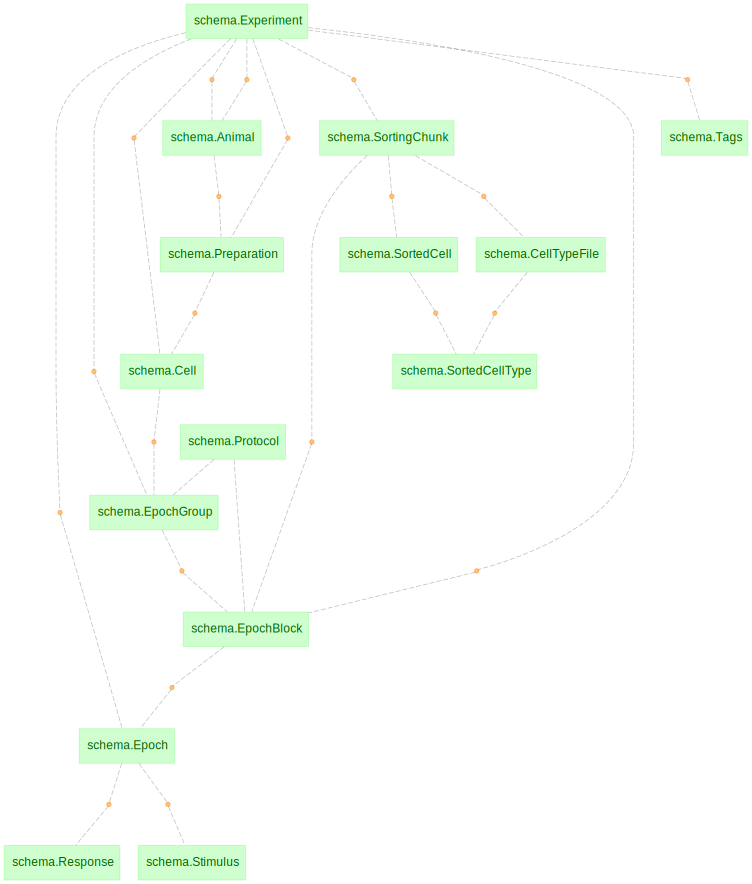

In [3]:
dj.Diagram(schema)

That's a lot to take in. Feel free to step through each table to see what's going on. I'll illustrate ways to look at the tables and fetch their data with the Experiment table.

In [4]:
schema.Experiment()

id,h5_uuid,exp_name,meta_file,"data_file empty if MEA for now, maybe should store ""/Volumes/data/data/sorted"" here?",tags_file,"is_mea 1 if MEA, 0 if not",date_added,label,properties,attributes,start_time,experimenter,institution,lab,project,rig,rig_type
1,7d981fc0-2b25-4c48-bc81-5c54f83fab8b,20230406C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230406C.json,/Volumes/data-1/data/h5/20230406C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/20230406C.json,1,2025-03-17 15:58:28,20230406,=BLOB=,=BLOB=,2023-04-06 15:36:35,None,None,None,None,None,MEA
2,498dcf21-b568-4687-9825-fb2458df1029,20230614C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230614C.json,/Volumes/data-1/data/h5/20230614C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/20230614C.json,1,2025-03-17 15:58:37,20230614,=BLOB=,=BLOB=,2023-06-14 08:21:20,None,None,None,None,None,MEA
3,a6a15586-597b-46f7-99cb-5b3933cf3b5d,20230629C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230629C.json,/Volumes/data-1/data/h5/20230629C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/20230629C.json,1,2025-03-17 15:59:49,20230629,=BLOB=,=BLOB=,2023-06-29 11:46:06,None,None,None,None,None,MEA
4,65489648-006d-4691-bc61-eecd7d766fa3,20230713C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230713C.json,/Volumes/data-1/data/h5/20230713C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/20230713C.json,1,2025-03-17 15:59:57,20230713,=BLOB=,=BLOB=,2023-07-13 10:33:01,None,None,None,None,None,MEA
5,440fb989-fb5e-422e-9cc7-a40f6ca6b6e7,20230719C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20230719C.json,/Volumes/data-1/data/h5/20230719C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/20230719C.json,1,2025-03-17 16:00:23,20230719,=BLOB=,=BLOB=,2023-07-19 07:46:28,None,None,None,None,None,MEA
6,1ddf450b-5bbb-44a3-8b98-eb6fa144e9a6,20240418H,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20240418H.json,/Volumes/data-1/data/h5/20240418H.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/20240418H.json,1,2025-03-17 16:02:32,20240418,=BLOB=,=BLOB=,2024-04-18 10:21:18,None,None,None,None,None,MEA
7,501a25d2-cc07-425d-9059-ed4fd25d5653,20220406C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220406C.json,/Volumes/data-1/data/h5/20220406C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/20220406C.json,1,2025-03-17 16:03:59,20220406,=BLOB=,=BLOB=,2022-04-06 11:31:22,None,None,None,None,None,MEA
8,09f80247-89e5-4251-859c-3c3fcf1f203e,20220412C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220412C.json,/Volumes/data-1/data/h5/20220412C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/20220412C.json,1,2025-03-17 16:04:04,20220412,=BLOB=,=BLOB=,2022-04-12 09:10:16,None,None,None,None,None,MEA
9,94afe5fc-b406-4fea-8df7-a1cee9aec9f1,20220420C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220420C.json,/Volumes/data-1/data/h5/20220420C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/20220420C.json,1,2025-03-17 16:08:45,20220420,=BLOB=,=BLOB=,2022-04-20 13:00:04,None,None,None,None,None,MEA
10,b0637fe4-0093-41dd-be9d-8b75f4cd1101,20220426C,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/meta/20220426C.json,/Volumes/data-1/data/h5/20220426C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data_dirs/tags/20220426C.json,1,2025-03-17 16:18:08,20220426,=BLOB=,=BLOB=,2022-04-26 10:45:18,None,None,None,None,None,MEA


In [5]:
df = schema.Experiment().fetch(format='frame').reset_index()
df.head()

,id,h5_uuid,exp_name,meta_file,data_file,tags_file,is_mea,date_added,label,properties,attributes,start_time,experimenter,institution,lab,project,rig,rig_type
0,1,7d981fc0-2b25-4c48-bc81-5c54f83fab8b,20230406C,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,/Volumes/data-1/data/h5/20230406C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,1,2025-03-17 15:58:28,20230406,"{'id': None, 'age': None, 'sex': None, 'weight...",{'uuid': '7d981fc0-2b25-4c48-bc81-5c54f83fab8b...,2023-04-06 15:36:35,None,None,None,None,None,MEA
1,2,498dcf21-b568-4687-9825-fb2458df1029,20230614C,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,/Volumes/data-1/data/h5/20230614C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,1,2025-03-17 15:58:37,20230614,"{'id': 'A22088', 'age': '3 yo', 'sex': 'female...",{'uuid': '498dcf21-b568-4687-9825-fb2458df1029...,2023-06-14 08:21:20,None,None,None,None,None,MEA
2,3,a6a15586-597b-46f7-99cb-5b3933cf3b5d,20230629C,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,/Volumes/data-1/data/h5/20230629C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,1,2025-03-17 15:59:49,20230629,"{'id': None, 'age': None, 'sex': None, 'weight...",{'uuid': 'a6a15586-597b-46f7-99cb-5b3933cf3b5d...,2023-06-29 11:46:06,None,None,None,None,None,MEA
3,4,65489648-006d-4691-bc61-eecd7d766fa3,20230713C,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,/Volumes/data-1/data/h5/20230713C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,1,2025-03-17 15:59:57,20230713,"{'id': None, 'age': None, 'sex': None, 'weight...",{'uuid': '65489648-006d-4691-bc61-eecd7d766fa3...,2023-07-13 10:33:01,None,None,None,None,None,MEA
4,5,440fb989-fb5e-422e-9cc7-a40f6ca6b6e7,20230719C,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,/Volumes/data-1/data/h5/20230719C.h5,/Volumes/Vyom MEA/data/samarjit_datajoint/data...,1,2025-03-17 16:00:23,20230719,"{'id': 'Z21142', 'age': '1 yr 11 mo', 'sex': '...",{'uuid': '440fb989-fb5e-422e-9cc7-a40f6ca6b6e7...,2023-07-19 07:46:28,None,None,None,None,None,MEA


When pulling as a pandas dataframe, it's generally helpful to call `reset_index` so you end up with a single 0-based index.

## Querying Workflow
You shouldn't need to step through individual tables for a typical workflow, as there should be utility functions for desired steps. If there isn't a function, help us make one and add it to `djutils`!

In [6]:
import importlib
importlib.reload(dju)
exp_name = '20230614C'
df = dju.mea_exp_summary(exp_name)
df.head()

,data_dir,group_label,NDF,chunk_name,protocol_name,experiment_id,group_id,block_id,chunk_id,protocol_id
0,20230614C/data000,noise,0.0,chunk1,manookinlab.protocols.FastNoise,2,9,9,1,17
1,20230614C/data001,delta size noise,0.0,chunk1,manookinlab.protocols.NoiseSizeModulation,2,10,10,1,18
2,20230614C/data002,delta time noise,0.0,chunk1,manookinlab.protocols.NoiseSizeModulation,2,11,11,1,18
3,20230614C/data003,crf,0.0,chunk1,manookinlab.protocols.ContrastResponseGrating,2,12,12,1,5
4,20230614C/data004,adapt noise spatial,0.0,chunk1,manookinlab.protocols.AdaptNoiseColorSteps,2,13,13,1,19


This lets me see a nice summary of an MEA experiment day. 

Let's query for a specific protocol.

In [7]:
import importlib
importlib.reload(dju)
ls_protocols = dju.search_protocol('MovingChromaticBar')
print(ls_protocols)

['manookinlab.protocols.MovingChromaticBar']


Get associated metadata for this protocol.

In [8]:
import importlib
importlib.reload(dju)
df_meta = dju.mea_meta_from_protocols(ls_protocols)
df_meta.head()

,data_dir,group_label,NDF,chunk_name,protocol_name,exp_name,data_xxx,is_mea,experiment_id,protocol_id,group_id,block_id,chunk_id
0,20230614C/data009,oriented bars,0.0,chunk2,manookinlab.protocols.MovingChromaticBar,20230614C,data009,1,2,11,18,18,2
1,20230614C/data018,oriented bars,0.0,chunk3,manookinlab.protocols.MovingChromaticBar,20230614C,data018,1,2,11,26,27,4
2,20230719C/data006,moving bars,0.0,chunk1,manookinlab.protocols.MovingChromaticBar,20230719C,data006,1,5,11,70,77,7
3,20230719C/data021,moving bars,0.0,chunk3,manookinlab.protocols.MovingChromaticBar,20230719C,data021,1,5,11,81,91,9
4,20220531C/data021,moving bar gray background,NaN,chunk2,manookinlab.protocols.MovingChromaticBar,20220531C,data021,1,13,11,175,402,11


Get any associated cell typing for these sorting chunks.

In [9]:
import importlib
importlib.reload(dju)
df_ct = dju.cell_typing_from_chunks(df_meta['chunk_id'], b_remove_zeros=True, 
                                    ls_cell_types=['OffP', 'OffM', 'OnP', 'OnM', 'SBC', 'Amacrine'])
df_ct.head()

No cell type matches found for 20230614C, chunk2, kilosort2.classification-FMR.txt
No cell type matches found for 20221123C, chunk1, kilosort2.classification.txt
No cell type matches found for 20230202C, chunk1, kilosort2.classification.txt
No cell type matches found for 20230202C, chunk1, kilosort2.classification_fmr.txt
No cell type matches found for 20230825C, chunk1, kilosort2.classification-FMR.txt


,exp_name,chunk_name,algorithm,typing_file_name,total_clusters,OffP,OffM,OnP,OnM,SBC,Amacrine,experiment_id,chunk_id,typing_file_id
0,20230614C,chunk3,kilosort2,kilosort2.classification.txt,518,76,75,34,54,0,5,2,4,4
1,20230614C,chunk3,kilosort2,kilosort2.classification-FMR.txt,923,143,154,55,120,0,1,2,4,5
2,20230719C,chunk3,kilosort2,autoClassification.txt,486,15,77,36,90,0,23,5,9,9
3,20220909C,chunk1,kilosort2,kilosort2.classification.txt,513,35,116,47,136,0,0,23,35,12
4,20221216C,chunk1,kilosort2,kilosort2.classification.txt,1319,63,146,41,79,0,24,30,59,16


Plot mosaics for queried datasets. Just plotting first 3 for illustration.

{'ls_cell_types': ['OffP', 'OffM', 'OnP', 'OnM', 'SBC', 'Amacrine']}
['OffP', 'OffM', 'OnP', 'OnM', 'SBC', 'Amacrine']
Loading STA from /Volumes/data-1/analysis/20230614C/chunk3/kilosort2/kilosort2.params...
Loaded STA for 923 cells.
Loading STA from /Volumes/data-1/analysis/20230614C/chunk3/kilosort2/kilosort2.params...
Loaded STA for 923 cells.


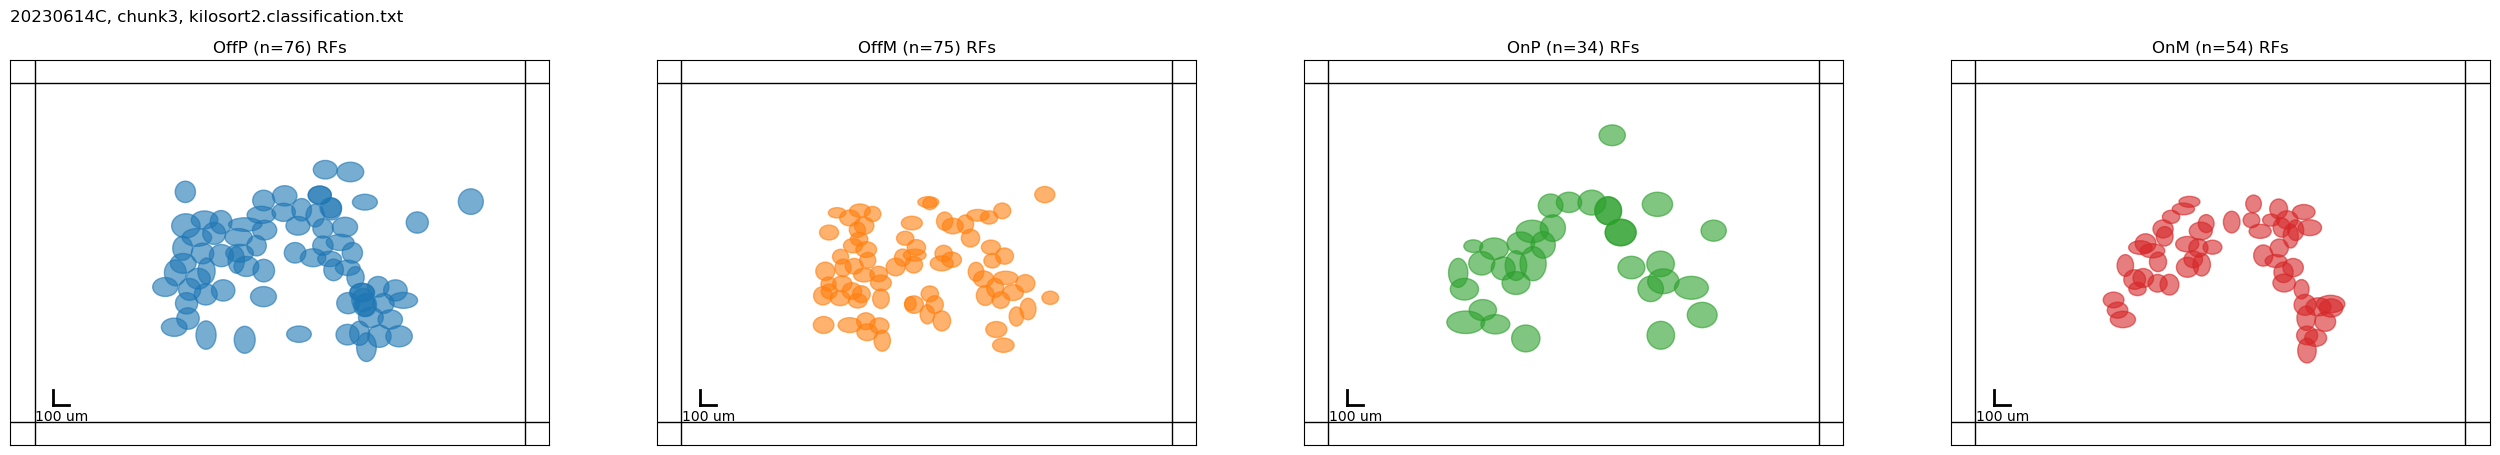

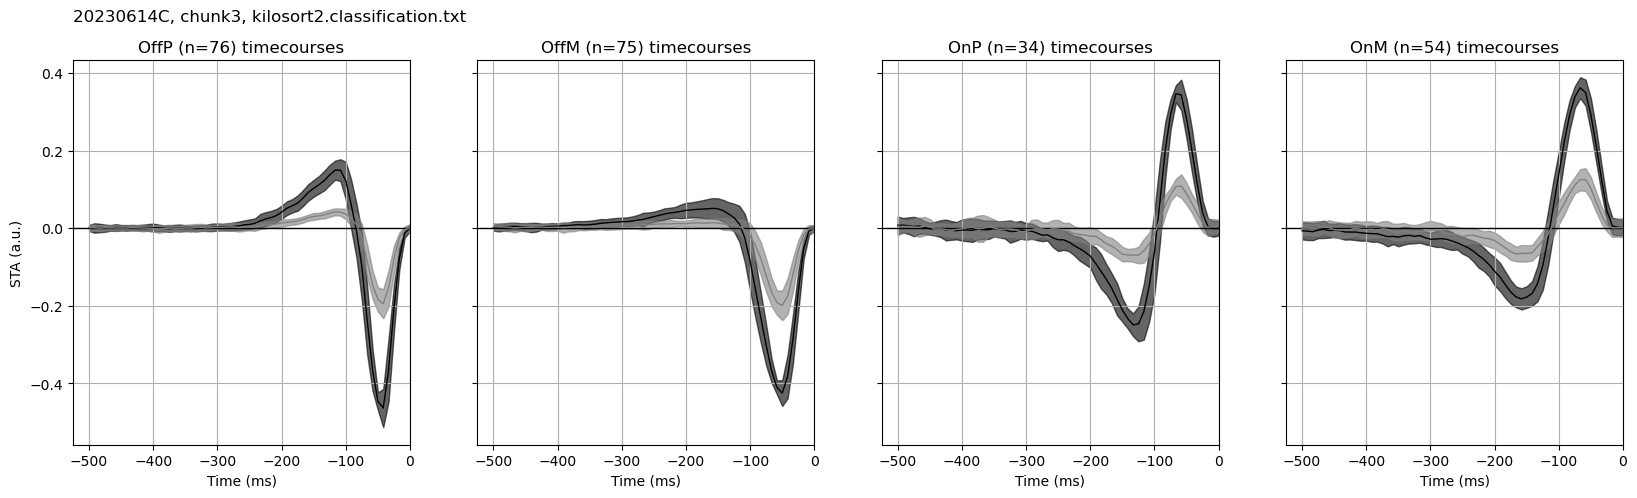

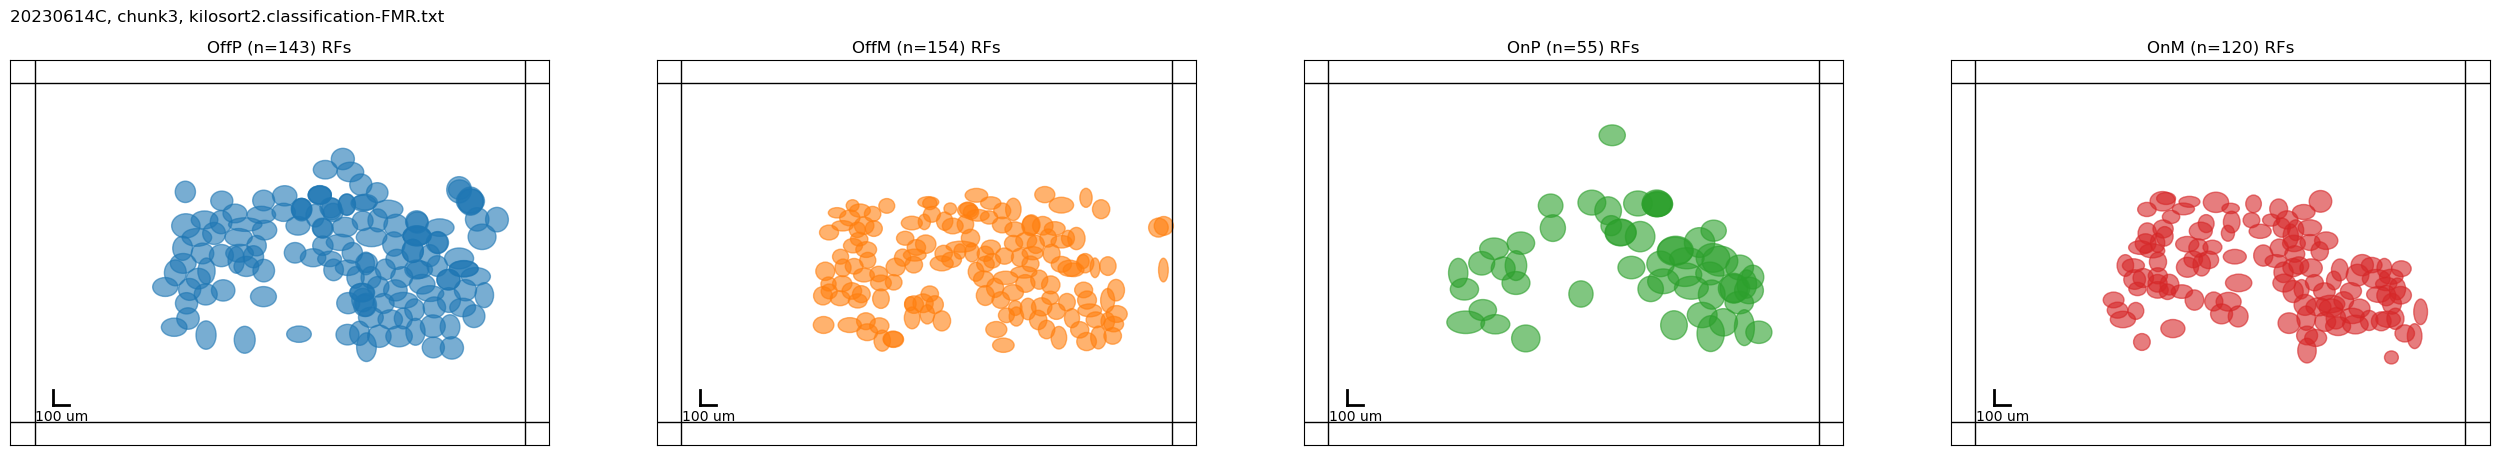

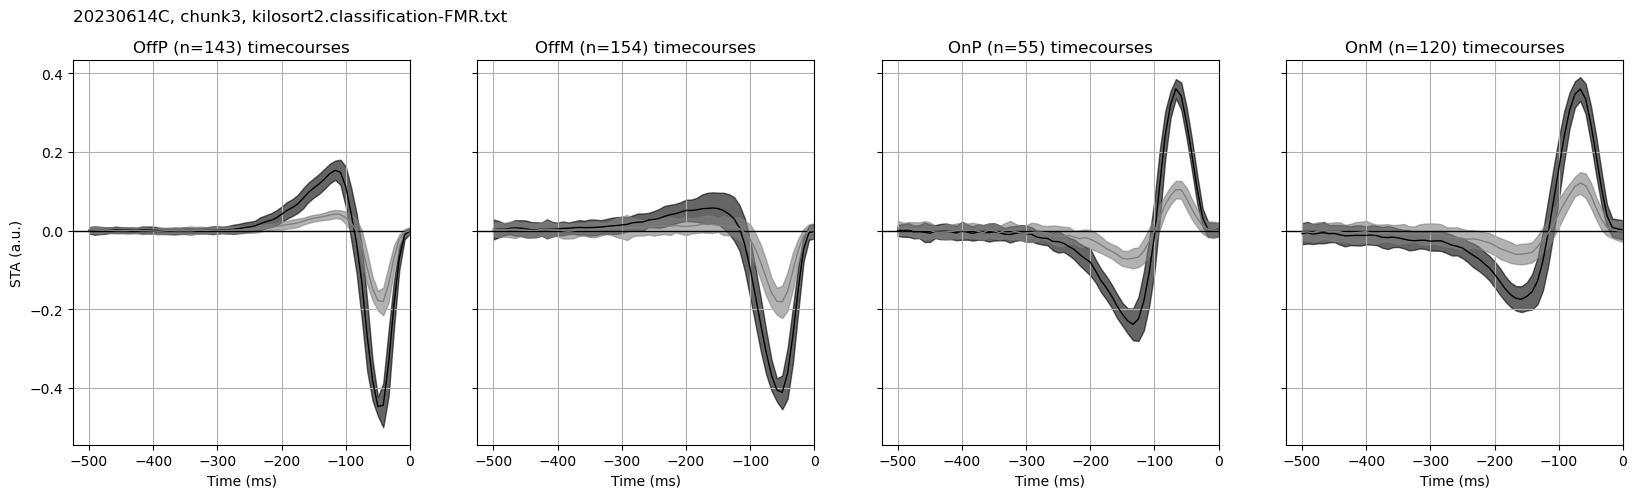

In [10]:
import importlib
importlib.reload(dju)
df_data = dju.mosaics_from_typing(df_ct.loc[:1], df_meta.loc[:1])

## Loading PSTHs

df_data has rows with all the metadata I need to construct a `SpikeOutputs` object that I use to manage a single dataset.

Most commonly, I use the `load_psth` function which uses `symphony_data` methods to load the PSTH.

In [13]:
df_data

,data_dir,group_label,NDF,chunk_name,protocol_name,exp_name,data_xxx,is_mea,experiment_id,protocol_id,...,algorithm,typing_file_name,total_clusters,OffP,OffM,OnP,OnM,SBC,Amacrine,typing_file_id
0,20230614C/data018,oriented bars,0.0,chunk3,manookinlab.protocols.MovingChromaticBar,20230614C,data018,1,2,11,...,kilosort2,kilosort2.classification.txt,518,76,75,34,54,0,5,4
1,20230614C/data018,oriented bars,0.0,chunk3,manookinlab.protocols.MovingChromaticBar,20230614C,data018,1,2,11,...,kilosort2,kilosort2.classification-FMR.txt,923,143,154,55,120,0,1,5


In [27]:
str_protocol = 'movingchromaticbar'
importlib.reload(dju)
importlib.reload(so)
tfid = 5
print(str_protocol)
data = dju.mea_data_from_meta(df_data[df_data['typing_file_id'] == tfid], ls_cell_types=['OffP', 'OffM', 'OnP', 'OnM', 'SBC', 'Amacrine'])
ls_param_names = ['orientation', 'speed', 'contrast', 'barSize']
bin_rate = 100.0
data.load_sta_from_params()
data.load_psth(str_protocol, ls_param_names, bin_rate)

movingchromaticbar
Loading STA from /Volumes/data-1/analysis/20230614C/chunk3/kilosort2/kilosort2.params...
Loaded STA for 923 cells.
Processing group 1 of 1 and block 1 of 1
Updating GOOD_CELL_IDS to 850 cells.
OffP: 126/143
OffM: 150/154
OnP: 46/55
OnM: 119/120
Amacrine: 1/1
Loading ISI for movingchromaticbar ['data018']...
Processing group 1 of 1 and block 1 of 1
Loaded ISI for 859 cells.


In [28]:
data.print_stim_summary()

epoch length: 7000.0 ms
Total epochs: 192
pre: 500.0 ms; stim: 6000.0 ms; tail: 500.0 ms
pre pts: 50; stim pts: 600; tail pts: 50
bin rate: 100.0 Hz; bin dt: 10.0 ms


In [29]:
data.stim['unique_params']

{'orientation': array([  0.,  30.,  60.,  90., 120., 150., 180., 210., 240., 270., 300.,
        330.]),
 'speed': array([600.]),
 'contrast': array([-1.,  1.]),
 'barSize': array([ 200., 4000.])}

This gives me everything I need for further analysis :)

For instance, let's plot the OnP PSTHs when orientation was 0 and contrast was 1

In [30]:
contrast = 1.0
orientation = 0.0
epochs = np.where((data.stim['params']['contrast'] == contrast) & (data.stim['params']['orientation'] == orientation))[0]
print(f'{len(epochs)} epochs found')

8 epochs found


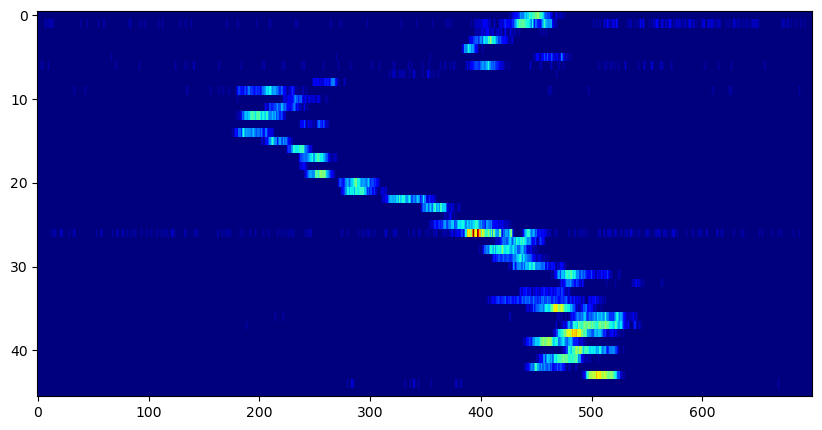

In [31]:
str_cell_type = 'OnP'
cell_ids = data.get_type_ids(str_cell_type)

psth = [data.spikes['spike_dict'][id][epochs].mean(axis=0) for id in cell_ids]
psth = np.array(psth)

f, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(psth, aspect='auto', cmap='jet', interpolation='none')

This works pretty cleanly when staying within the same spike sorting chunk. For protocols spike sorted separately, you would need to add an EI mapping step to carry over the cell type labels from WN.

I have code for this, and for QC on the cells based on ISI violations, firing rate in `eicorr` and `meaqc` modules. Can share a tutorial for this later.

## Endnotes
Here are some other things that you could do that I haven't illustrated here:
- Epoch level parameter queries (eg-movingbar with particular range of speeds)
- Compute protocol analysis value for all cells across many datasets (eg-find DS/OS/OMS cells)